# Classically Punk Project

### Importing The Dataset

dataset link = https://storage.googleapis.com/qwasar-public/track-ds/classically_punk_music_genres.tar.gz

In [1]:
import tarfile
from datetime import datetime

# Start the timer to track runtime
start = datetime.now()

# Open the .tar.gz file with the appropriate mode ('r:gz')
with tarfile.open('classically_punk_music_genres.tar.gz', 'r:gz') as tar:
    tar.extractall("extracted_data") 

# Print the success message and runtime
print(f"Dataset Successfully opened\nRun time: {datetime.now() - start}")

Dataset Successfully opened
Run time: 0:02:12.785639


In [2]:
import os
print(os.listdir("extracted_data"))

['genres']


In [3]:
import os

folder_path = "extracted_data"

# List only directories inside the folder
folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

print("Folders inside:", folders)

Folders inside: ['genres']


In [4]:
#Extraxting file paths

import os
import pandas as pd

folder_path = "extracted_data" 

# Initialize a list to store file details
data = []

# Walk through the directory to get audio file paths
s_n = 1
for root, _, files in os.walk(folder_path):
    genre_name = os.path.basename(root)
    for file in files:
        if file.lower().endswith((".mp3", ".wav", ".flac", ".aac", ".ogg")):
            file_path = os.path.join(root, file)
            data.append([s_n, file_path, genre_name])
            s_n += 1

In [5]:
# Creating a DataFrame
df = pd.DataFrame(data, columns=["S/N", "File Path", "Genre Name"])

In [6]:
# Display the first few rows
print(df.head())

   S/N                                    File Path Genre Name
0    1  extracted_data\genres\blues\blues.00000.wav      blues
1    2  extracted_data\genres\blues\blues.00001.wav      blues
2    3  extracted_data\genres\blues\blues.00002.wav      blues
3    4  extracted_data\genres\blues\blues.00003.wav      blues
4    5  extracted_data\genres\blues\blues.00004.wav      blues


In [7]:
df.tail()

S/N                                  File Path Genre Name
995   996  extracted_data\genres\rock\rock.00095.wav       rock
996   997  extracted_data\genres\rock\rock.00096.wav       rock
997   998  extracted_data\genres\rock\rock.00097.wav       rock
998   999  extracted_data\genres\rock\rock.00098.wav       rock
999  1000  extracted_data\genres\rock\rock.00099.wav       rock

In [8]:
# Save to CSV if needed
df.to_csv("audio_files_metadata.csv", index=False)

In [9]:
print(df.tail())

      S/N                                  File Path Genre Name
995   996  extracted_data\genres\rock\rock.00095.wav       rock
996   997  extracted_data\genres\rock\rock.00096.wav       rock
997   998  extracted_data\genres\rock\rock.00097.wav       rock
998   999  extracted_data\genres\rock\rock.00098.wav       rock
999  1000  extracted_data\genres\rock\rock.00099.wav       rock


#### From the data we can see in our dataset, We need more features to be able to do ML algorithm on it.
#### There are libraries for auido feature extraction in audio files. We will be using Librosa in this project

In [10]:
import librosa

In [11]:
import os
import librosa
import librosa.beat
import librosa.display

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Music Genre Classification
#### Recommended features : MFCC Mean , Chroma , Spectral Centroid , Spectral Roll-off , Tempo (BPM) , RMSE Energy.
#### Why : These features capture both spectral and rhythmic characteristics, which are critical for distinguishing between genres.

In [13]:
#Extracting Music Features

def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        print(f"Processing: {file_path}")  # Debugging

        # MFCC (Mean, Variance, Skewness)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_var = np.var(mfccs, axis=1)
        mfcc_skew = np.mean((mfccs - mfcc_mean[:, None]) ** 3, axis=1)

        # Spectral Features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()

        # Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y).mean()

        # Tempo
        tempo = librosa.feature.rhythm.tempo(y=y, sr=sr)[0]

        # RMS Energy (Mean & Variance)
        rms = librosa.feature.rms(y=y)
        rms_mean = rms.mean()
        rms_var = rms.var()

        # Chroma STFT
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_agg = [chroma_stft.mean(), chroma_stft.var(), chroma_stft.max(), chroma_stft.min()]

        return {
            "MFCC Mean": list(mfcc_mean),
            "MFCC Variance": list(mfcc_var),
            "MFCC Skewness": list(mfcc_skew),
            "Spectral Centroid": spectral_centroid,
            "Spectral Roll-off": spectral_rolloff,
            "Zero-Crossing Rate": zcr,
            "Tempo (BPM)": tempo,
            "RMS Energy Mean": rms_mean,
            "RMS Energy Variance": rms_var,
            "Chroma STFT": chroma_agg
        }

    except Exception as e:
        print(f"❌ Librosa failed for {file_path}: {e}")
        return None


In [14]:
# 📌 Function to process the dataset
def process_audio_dataset(folder_path):
    data = []
    s_n = 1  # Serial number

    for root, _, files in os.walk(folder_path):
        genre_name = os.path.basename(root)  # Folder name as Genre
        for file in files:
            if file.lower().endswith((".mp3", ".wav", ".flac", ".aac", ".ogg")):
                file_path = os.path.join(root, file)

                audio_features = extract_audio_features(file_path)

                if audio_features: 
                    data.append([
                        s_n, genre_name, file, file_path,
                        *audio_features["MFCC Mean"],
                        *audio_features["MFCC Variance"],
                        *audio_features["MFCC Skewness"],
                        audio_features["Spectral Centroid"],
                        audio_features["Spectral Roll-off"],
                        audio_features["Zero-Crossing Rate"],
                        audio_features["Tempo (BPM)"],
                        audio_features["RMS Energy Mean"],
                        audio_features["RMS Energy Variance"],
                        *audio_features["Chroma STFT"]
                    ])
                    s_n += 1

    # Creating the DataFrame
    mfcc_columns = [f"MFCC Mean {i+1}" for i in range(13)] + \
                   [f"MFCC Variance {i+1}" for i in range(13)] + \
                   [f"MFCC Skewness {i+1}" for i in range(13)]

    chroma_columns = ["Chroma Mean", "Chroma Variance", "Chroma Max", "Chroma Min"]

    columns = ["S/N", "Genre Name", "File Name", "File Path"] + \
              mfcc_columns + [
                  "Spectral Centroid", "Spectral Roll-off",
                  "Zero-Crossing Rate", "Tempo (BPM)",
                  "RMS Energy Mean", "RMS Energy Variance"
              ] + chroma_columns

    df = pd.DataFrame(data, columns=columns)

    if df.empty:
        print("⚠️ No valid audio files found. Check your folder path!")

    return df


In [15]:
# Run the function
folder_path = "extracted_data"  # Change this to your dataset path
df = process_audio_dataset(folder_path)

Processing: extracted_data\genres\blues\blues.00000.wav
Processing: extracted_data\genres\blues\blues.00001.wav
Processing: extracted_data\genres\blues\blues.00002.wav
Processing: extracted_data\genres\blues\blues.00003.wav
Processing: extracted_data\genres\blues\blues.00004.wav
Processing: extracted_data\genres\blues\blues.00005.wav
Processing: extracted_data\genres\blues\blues.00006.wav
Processing: extracted_data\genres\blues\blues.00007.wav
Processing: extracted_data\genres\blues\blues.00008.wav
Processing: extracted_data\genres\blues\blues.00009.wav
Processing: extracted_data\genres\blues\blues.00010.wav
Processing: extracted_data\genres\blues\blues.00011.wav
Processing: extracted_data\genres\blues\blues.00012.wav
Processing: extracted_data\genres\blues\blues.00013.wav
Processing: extracted_data\genres\blues\blues.00014.wav
Processing: extracted_data\genres\blues\blues.00015.wav
Processing: extracted_data\genres\blues\blues.00016.wav
Processing: extracted_data\genres\blues\blues.00

In [16]:
# Display output
print(df.head())

   S/N Genre Name        File Name  \
0    1      blues  blues.00000.wav   
1    2      blues  blues.00001.wav   
2    3      blues  blues.00002.wav   
3    4      blues  blues.00003.wav   
4    5      blues  blues.00004.wav   

                                     File Path  MFCC Mean 1  MFCC Mean 2  \
0  extracted_data\genres\blues\blues.00000.wav  -113.598824   121.570671   
1  extracted_data\genres\blues\blues.00001.wav  -207.523834   123.985138   
2  extracted_data\genres\blues\blues.00002.wav   -90.757164   140.440872   
3  extracted_data\genres\blues\blues.00003.wav  -199.575134   150.086105   
4  extracted_data\genres\blues\blues.00004.wav  -160.354172   126.209480   

   MFCC Mean 3  MFCC Mean 4  MFCC Mean 5  MFCC Mean 6  ...  Spectral Centroid  \
0   -19.162262    42.363941    -6.362266    18.621931  ...        1784.122641   
1     8.947019    35.867149     2.909595    21.519474  ...        1530.261767   
2   -29.084547    31.686693   -13.976547    25.753752  ...        1552.

In [17]:
df.head()

S/N Genre Name        File Name  \
0    1      blues  blues.00000.wav   
1    2      blues  blues.00001.wav   
2    3      blues  blues.00002.wav   
3    4      blues  blues.00003.wav   
4    5      blues  blues.00004.wav   

                                     File Path  MFCC Mean 1  MFCC Mean 2  \
0  extracted_data\genres\blues\blues.00000.wav  -113.598824   121.570671   
1  extracted_data\genres\blues\blues.00001.wav  -207.523834   123.985138   
2  extracted_data\genres\blues\blues.00002.wav   -90.757164   140.440872   
3  extracted_data\genres\blues\blues.00003.wav  -199.575134   150.086105   
4  extracted_data\genres\blues\blues.00004.wav  -160.354172   126.209480   

   MFCC Mean 3  MFCC Mean 4  MFCC Mean 5  MFCC Mean 6  ...  Spectral Centroid  \
0   -19.162262    42.363941    -6.362266    18.621931  ...        1784.122641   
1     8.947019    35.867149     2.909595    21.519474  ...        1530.261767   
2   -29.084547    31.686693   -13.976547    25.753752  ...        1552.832482   
3     5.663404    26.855278     1.770071    14.232647  ...        1070.153417   
4   -35.581394    22.139257   -32.473549    10.850701  ...        1835.128513   

   Spectral Roll-off  Zero-Crossing Rate  Tempo (BPM)  RMS Energy Mean  \
0        3805.723030            0.083045   123.046875         0.130184   
1        3550.713616            0.056040   107.666016         0.095908   
2        3042.410115            0.076291   161.499023         0.175473   
3        2184.879029            0.033309   172.265625         0.141040   
4        3579.957471            0.101461   135.999178         0.091501   

   RMS Energy Variance  Chroma Mean  Chroma Variance  Chroma Max  Chroma Min  
0             0.002828     0.350129         0.088772         1.0    0.001883  
1             0.002373     0.340849         0.094976         1.0    0.001808  
2             0.002751     0.363538         0.085257         1.0    0.003168  
3             0.006348     0.404854         0.093999         1.0    0.005738  
4             0.002305     0.308526         0.087843         1.0    0.001347  

[5 rows x 53 columns]

In [18]:
# Save to CSV
df.to_csv("audio_features_dataset.csv", index=False)
print("✅ Dataset saved as audio_features_dataset.csv")

✅ Dataset saved as audio_features_dataset.csv


## Exploratory Data Analysis

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 53 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   S/N                  1000 non-null   int64  
 1   Genre Name           1000 non-null   object 
 2   File Name            1000 non-null   object 
 3   File Path            1000 non-null   object 
 4   MFCC Mean 1          1000 non-null   float32
 5   MFCC Mean 2          1000 non-null   float32
 6   MFCC Mean 3          1000 non-null   float32
 7   MFCC Mean 4          1000 non-null   float32
 8   MFCC Mean 5          1000 non-null   float32
 9   MFCC Mean 6          1000 non-null   float32
 10  MFCC Mean 7          1000 non-null   float32
 11  MFCC Mean 8          1000 non-null   float32
 12  MFCC Mean 9          1000 non-null   float32
 13  MFCC Mean 10         1000 non-null   float32
 14  MFCC Mean 11         1000 non-null   float32
 15  MFCC Mean 12         1000 non-null   fl

In [20]:
print(df.head(6))

   S/N Genre Name        File Name  \
0    1      blues  blues.00000.wav   
1    2      blues  blues.00001.wav   
2    3      blues  blues.00002.wav   
3    4      blues  blues.00003.wav   
4    5      blues  blues.00004.wav   
5    6      blues  blues.00005.wav   

                                     File Path  MFCC Mean 1  MFCC Mean 2  \
0  extracted_data\genres\blues\blues.00000.wav  -113.598824   121.570671   
1  extracted_data\genres\blues\blues.00001.wav  -207.523834   123.985138   
2  extracted_data\genres\blues\blues.00002.wav   -90.757164   140.440872   
3  extracted_data\genres\blues\blues.00003.wav  -199.575134   150.086105   
4  extracted_data\genres\blues\blues.00004.wav  -160.354172   126.209480   
5  extracted_data\genres\blues\blues.00005.wav  -177.801743   118.203163   

   MFCC Mean 3  MFCC Mean 4  MFCC Mean 5  MFCC Mean 6  ...  Spectral Centroid  \
0   -19.162262    42.363941    -6.362266    18.621931  ...        1784.122641   
1     8.947019    35.867149     2.9095

In [21]:
df.shape

(1000, 53)

In [22]:
df.describe()

S/N  MFCC Mean 1  MFCC Mean 2  MFCC Mean 3  MFCC Mean 4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    500.500000  -144.497314    99.553444    -8.922611    36.290348   
std     288.819436   100.218666    31.323814    21.687531    16.664284   
min       1.000000  -552.158630    -1.471578   -89.865089   -18.756536   
25%     250.750000  -200.773685    76.771477   -24.217540    24.103015   
50%     500.500000  -120.327309    98.453495   -10.714301    36.950199   
75%     750.250000   -73.962498   119.943155     5.503841    48.196013   
max    1000.000000    42.091446   193.074463    56.646450    80.698349   

       MFCC Mean 5  MFCC Mean 6  MFCC Mean 7  MFCC Mean 8  MFCC Mean 9  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean     -1.148604    14.633726    -5.131887    10.119702    -6.996191  ...   
std      12.220747    11.840074     9.940074    10.463887     8.283717  ...   
min     -38.911591   -28.404940   -32.941410   -24.918982   -31.642633  ...   
25%      -9.981052     5.088649   -12.874062     1.608641   -13.259794  ...   
50%      -0.022447    15.005462    -5.724688     9.664306    -7.517234  ...   
75%       7.917778    23.851022     2.975985    18.724935    -0.381853  ...   
max      31.428141    45.175888    21.816221    49.018703    19.130726  ...   

       Spectral Centroid  Spectral Roll-off  Zero-Crossing Rate  Tempo (BPM)  \
count        1000.000000        1000.000000         1000.000000  1000.000000   
mean         2201.887215        4571.806734            0.103612   121.083184   
std           715.916104        1574.668275            0.041821    20.912611   
min           570.349904         749.740169            0.021697    69.837416   
25%          1627.911508        3380.327774            0.070244   103.359375   
50%          2209.334372        4658.370426            0.099503   117.453835   
75%          2691.335270        5533.854176            0.131944   135.999178   
max          4435.732060        8677.730976            0.274631   184.570312   

       RMS Energy Mean  RMS Energy Variance  Chroma Mean  Chroma Variance  \
count      1000.000000          1000.000000  1000.000000      1000.000000   
mean          0.130858             0.003051     0.378719         0.086345   
std           0.065646             0.003633     0.081704         0.007739   
min           0.005270             0.000004     0.171896         0.044571   
25%           0.086612             0.000941     0.319612         0.082358   
50%           0.122382             0.001823     0.383192         0.086616   
75%           0.175591             0.003583     0.435652         0.091259   
max           0.397734             0.027704     0.663652         0.108058   

       Chroma Max   Chroma Min  
count      1000.0  1000.000000  
mean          1.0     0.004904  
std           0.0     0.007262  
min           1.0     0.000000  
25%           1.0     0.000966  
50%           1.0     0.002350  
75%           1.0     0.005789  
max           1.0     0.062504  

[8 rows x 50 columns]

In [23]:
df.columns.tolist()

['S/N',
 'Genre Name',
 'File Name',
 'File Path',
 'MFCC Mean 1',
 'MFCC Mean 2',
 'MFCC Mean 3',
 'MFCC Mean 4',
 'MFCC Mean 5',
 'MFCC Mean 6',
 'MFCC Mean 7',
 'MFCC Mean 8',
 'MFCC Mean 9',
 'MFCC Mean 10',
 'MFCC Mean 11',
 'MFCC Mean 12',
 'MFCC Mean 13',
 'MFCC Variance 1',
 'MFCC Variance 2',
 'MFCC Variance 3',
 'MFCC Variance 4',
 'MFCC Variance 5',
 'MFCC Variance 6',
 'MFCC Variance 7',
 'MFCC Variance 8',
 'MFCC Variance 9',
 'MFCC Variance 10',
 'MFCC Variance 11',
 'MFCC Variance 12',
 'MFCC Variance 13',
 'MFCC Skewness 1',
 'MFCC Skewness 2',
 'MFCC Skewness 3',
 'MFCC Skewness 4',
 'MFCC Skewness 5',
 'MFCC Skewness 6',
 'MFCC Skewness 7',
 'MFCC Skewness 8',
 'MFCC Skewness 9',
 'MFCC Skewness 10',
 'MFCC Skewness 11',
 'MFCC Skewness 12',
 'MFCC Skewness 13',
 'Spectral Centroid',
 'Spectral Roll-off',
 'Zero-Crossing Rate',
 'Tempo (BPM)',
 'RMS Energy Mean',
 'RMS Energy Variance',
 'Chroma Mean',
 'Chroma Variance',
 'Chroma Max',
 'Chroma Min']

In [24]:
df.isnull().sum()

S/N                    0
Genre Name             0
File Name              0
File Path              0
MFCC Mean 1            0
MFCC Mean 2            0
MFCC Mean 3            0
MFCC Mean 4            0
MFCC Mean 5            0
MFCC Mean 6            0
MFCC Mean 7            0
MFCC Mean 8            0
MFCC Mean 9            0
MFCC Mean 10           0
MFCC Mean 11           0
MFCC Mean 12           0
MFCC Mean 13           0
MFCC Variance 1        0
MFCC Variance 2        0
MFCC Variance 3        0
MFCC Variance 4        0
MFCC Variance 5        0
MFCC Variance 6        0
MFCC Variance 7        0
MFCC Variance 8        0
MFCC Variance 9        0
MFCC Variance 10       0
MFCC Variance 11       0
MFCC Variance 12       0
MFCC Variance 13       0
MFCC Skewness 1        0
MFCC Skewness 2        0
MFCC Skewness 3        0
MFCC Skewness 4        0
MFCC Skewness 5        0
MFCC Skewness 6        0
MFCC Skewness 7        0
MFCC Skewness 8        0
MFCC Skewness 9        0
MFCC Skewness 10       0


In [25]:
#checking duplicate values 
df.nunique()

S/N                    1000
Genre Name               10
File Name              1000
File Path              1000
MFCC Mean 1             986
MFCC Mean 2             986
MFCC Mean 3             986
MFCC Mean 4             986
MFCC Mean 5             986
MFCC Mean 6             986
MFCC Mean 7             986
MFCC Mean 8             986
MFCC Mean 9             986
MFCC Mean 10            986
MFCC Mean 11            986
MFCC Mean 12            986
MFCC Mean 13            986
MFCC Variance 1         986
MFCC Variance 2         986
MFCC Variance 3         986
MFCC Variance 4         986
MFCC Variance 5         986
MFCC Variance 6         986
MFCC Variance 7         986
MFCC Variance 8         986
MFCC Variance 9         986
MFCC Variance 10        986
MFCC Variance 11        986
MFCC Variance 12        986
MFCC Variance 13        986
MFCC Skewness 1         986
MFCC Skewness 2         986
MFCC Skewness 3         986
MFCC Skewness 4         986
MFCC Skewness 5         986
MFCC Skewness 6     

## Data Visualization

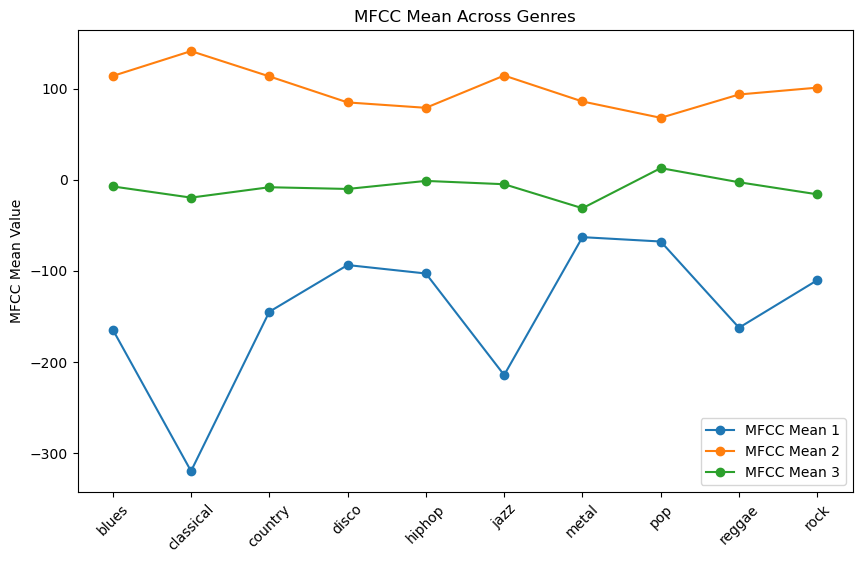

In [26]:
import matplotlib.pyplot as plt

def plot_mfcc_lineplot(df):
    mfcc_mean_cols = [f"MFCC Mean {i+1}" for i in range(3)]
    df_mean = df.groupby("Genre Name")[mfcc_mean_cols].mean().reset_index()

    plt.figure(figsize=(10, 6))
    for col in mfcc_mean_cols:
        plt.plot(df_mean["Genre Name"], df_mean[col], marker='o', label=col)
    plt.xticks(rotation=45)
    plt.ylabel("MFCC Mean Value")
    plt.title("MFCC Mean Across Genres")
    plt.legend()
    plt.show()

plot_mfcc_lineplot(df)

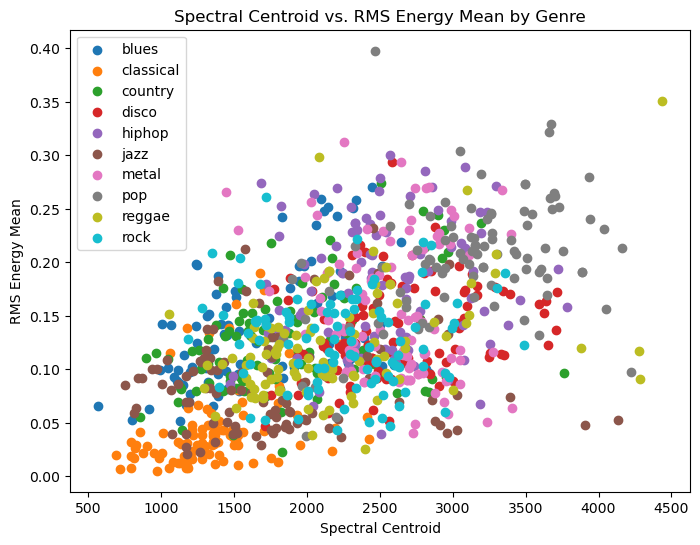

In [27]:
def plot_scatter(df):
    plt.figure(figsize=(8, 6))
    genres = df["Genre Name"].unique()
    for genre in genres:
        genre_df = df[df["Genre Name"] == genre]
        plt.scatter(genre_df["Spectral Centroid"], genre_df["RMS Energy Mean"], label=genre)
    plt.xlabel("Spectral Centroid")
    plt.ylabel("RMS Energy Mean")
    plt.title("Spectral Centroid vs. RMS Energy Mean by Genre")
    plt.legend()
    plt.show()

plot_scatter(df)

📢 Plotting waveform for: blues.00001.wav (blues)


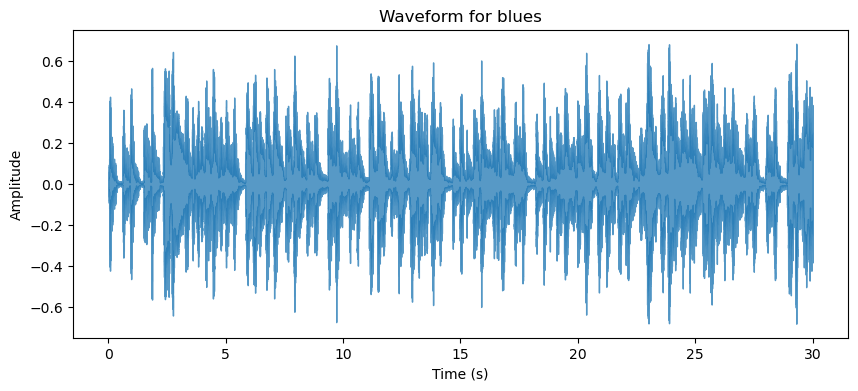

📢 Plotting waveform for: classical.00001.wav (classical)


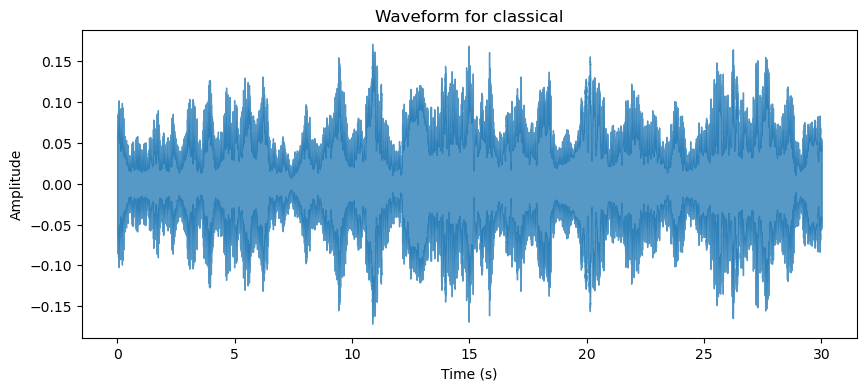

📢 Plotting waveform for: country.00001.wav (country)


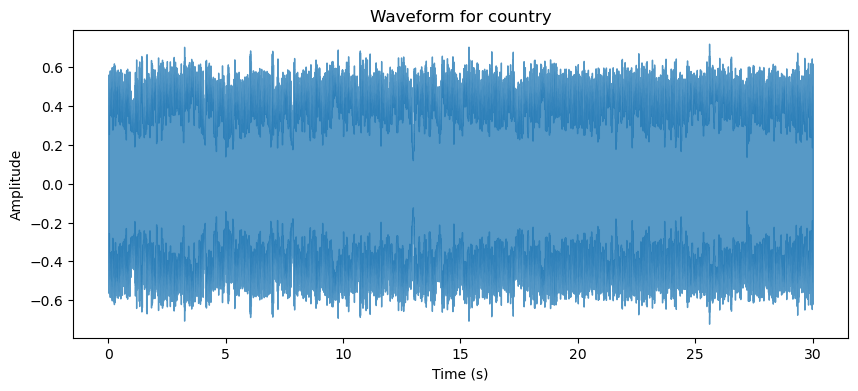

📢 Plotting waveform for: disco.00001.wav (disco)


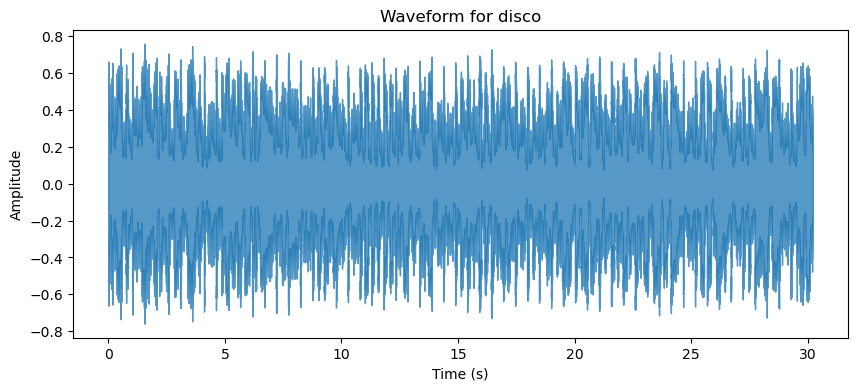

📢 Plotting waveform for: hiphop.00001.wav (hiphop)


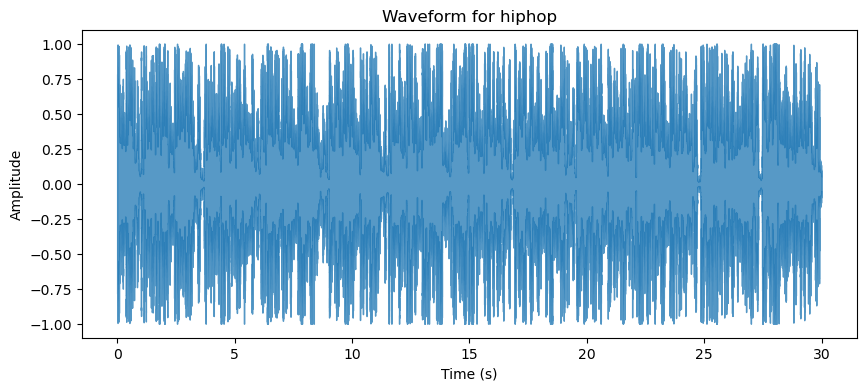

📢 Plotting waveform for: jazz.00001.wav (jazz)


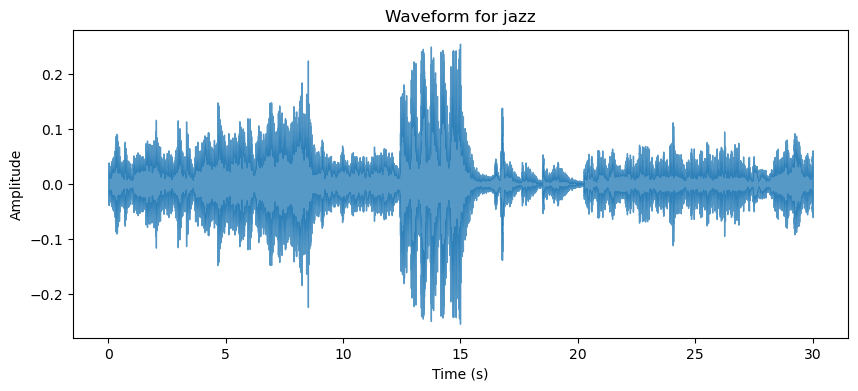

📢 Plotting waveform for: metal.00001.wav (metal)


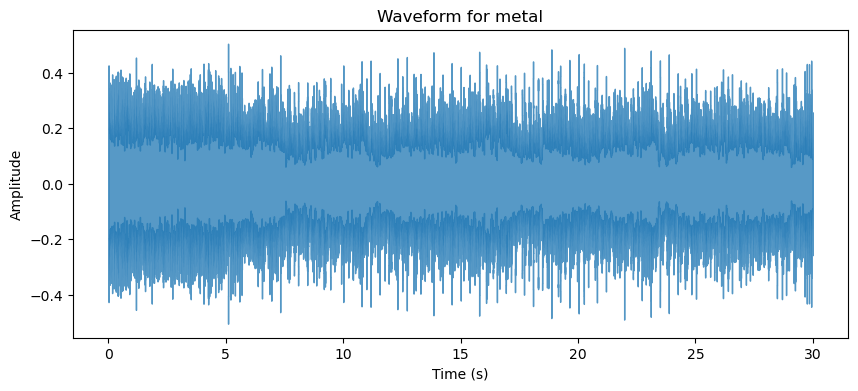

📢 Plotting waveform for: pop.00001.wav (pop)


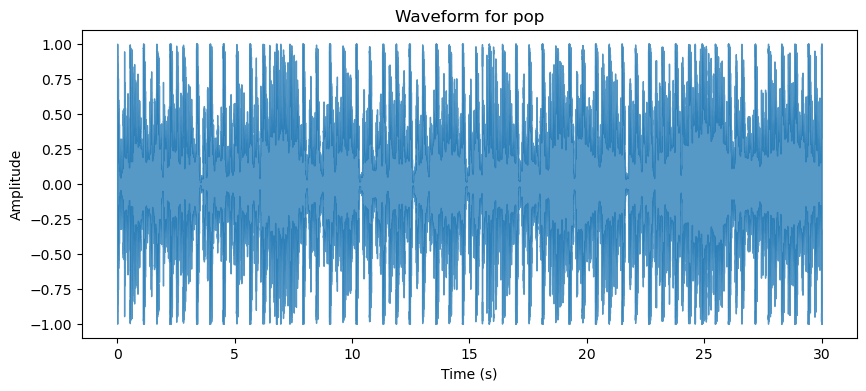

📢 Plotting waveform for: reggae.00001.wav (reggae)


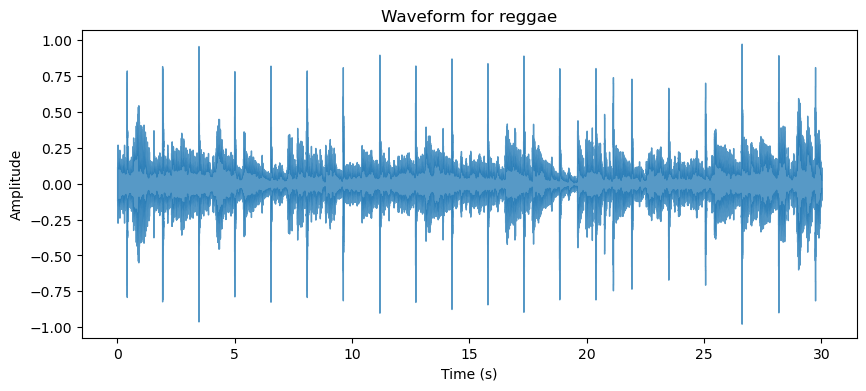

📢 Plotting waveform for: rock.00001.wav (rock)


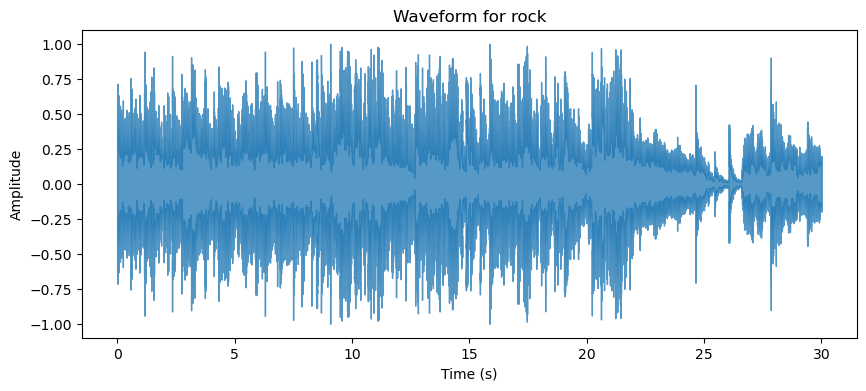

In [28]:
data_path = "extracted_data"

def plot_waveform(file_path, genre):
    y, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.75)
    plt.title(f"Waveform for {genre}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

for root, _, files in os.walk(data_path):
    genre = os.path.basename(root) 
    for file in files:
        if "00001" in file and file.lower().endswith((".mp3", ".wav", ".flac", ".aac", ".ogg")):
            file_path = os.path.join(root, file)
            print(f"📢 Plotting waveform for: {file} ({genre})")
            plot_waveform(file_path, genre)


📢 Plotting spectrogram for: blues.00005.wav (blues)


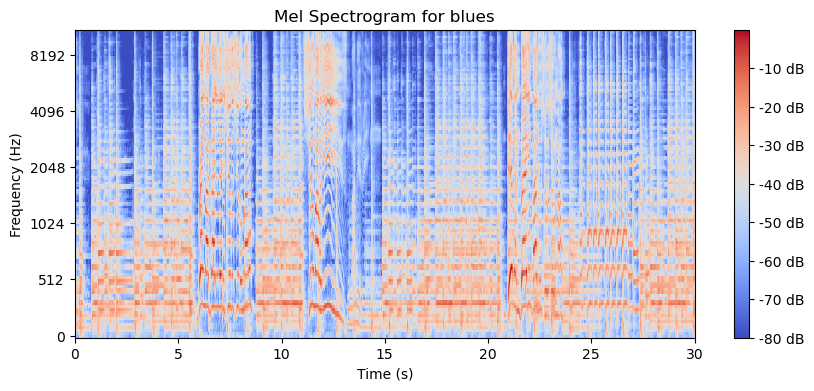

📢 Plotting spectrogram for: classical.00005.wav (classical)


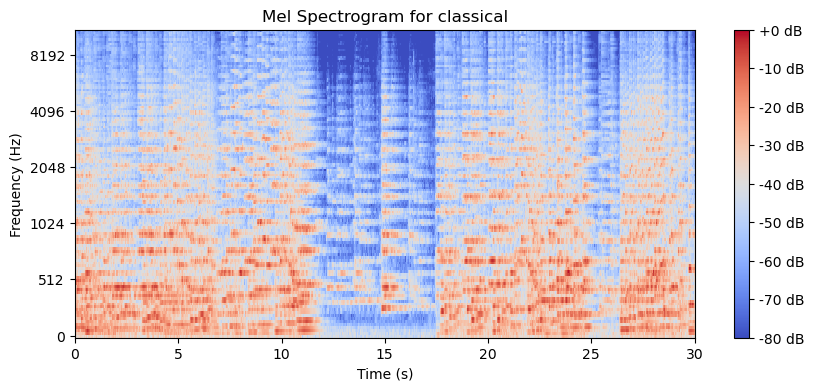

📢 Plotting spectrogram for: country.00005.wav (country)


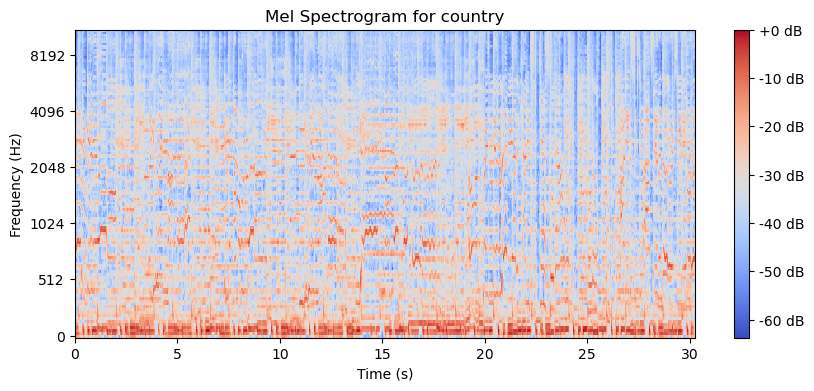

📢 Plotting spectrogram for: disco.00005.wav (disco)


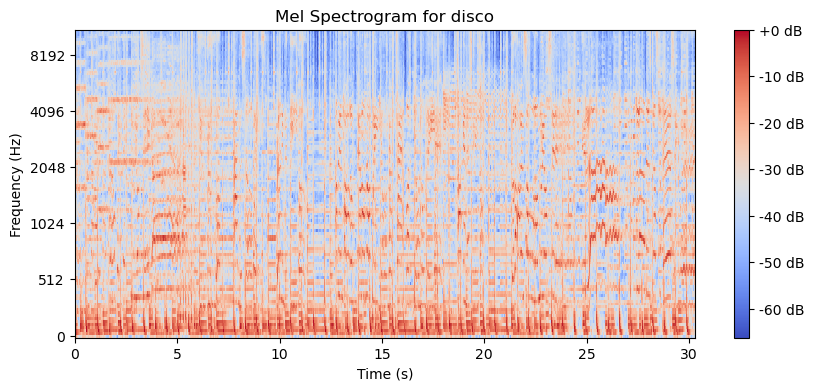

📢 Plotting spectrogram for: hiphop.00005.wav (hiphop)


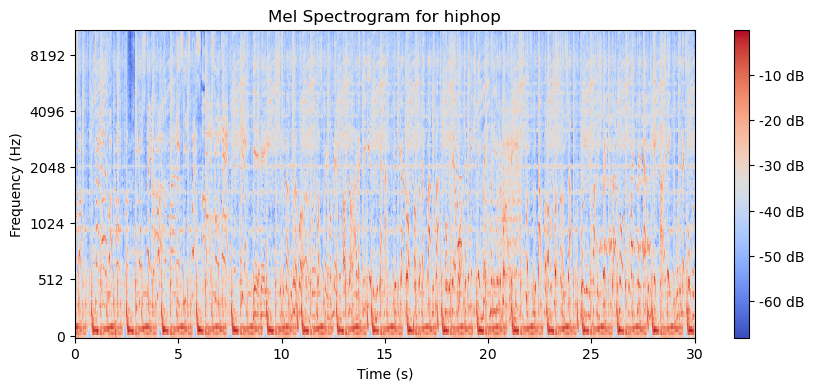

📢 Plotting spectrogram for: jazz.00005.wav (jazz)


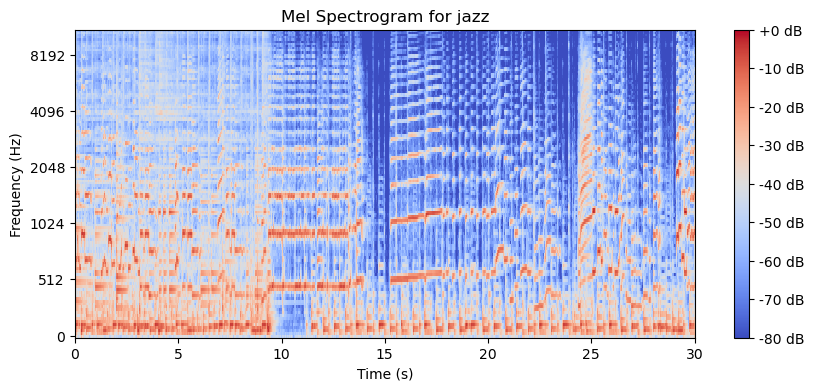

📢 Plotting spectrogram for: metal.00005.wav (metal)


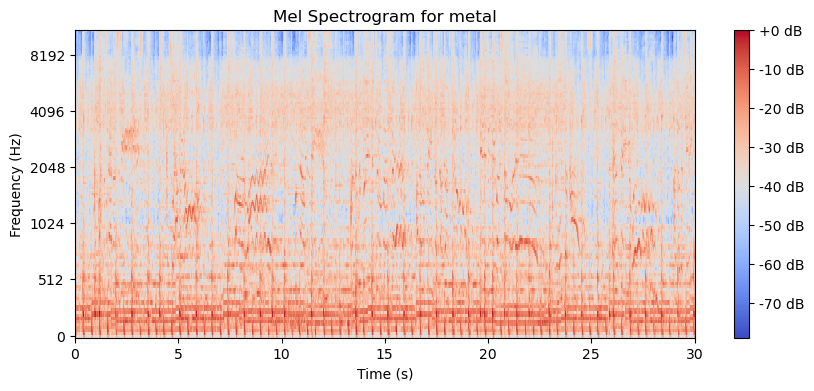

📢 Plotting spectrogram for: pop.00005.wav (pop)


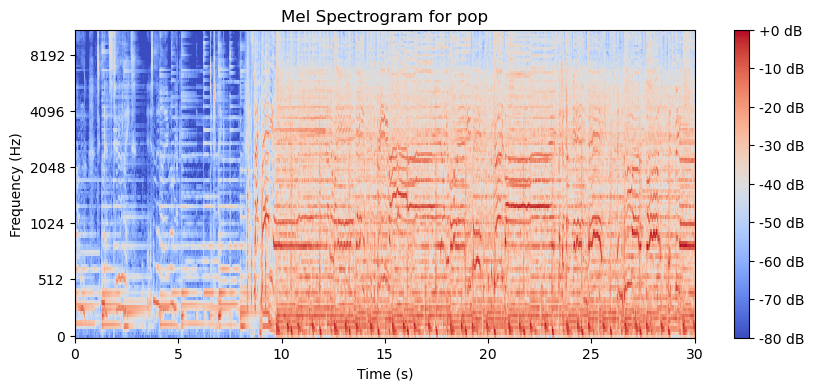

📢 Plotting spectrogram for: reggae.00005.wav (reggae)


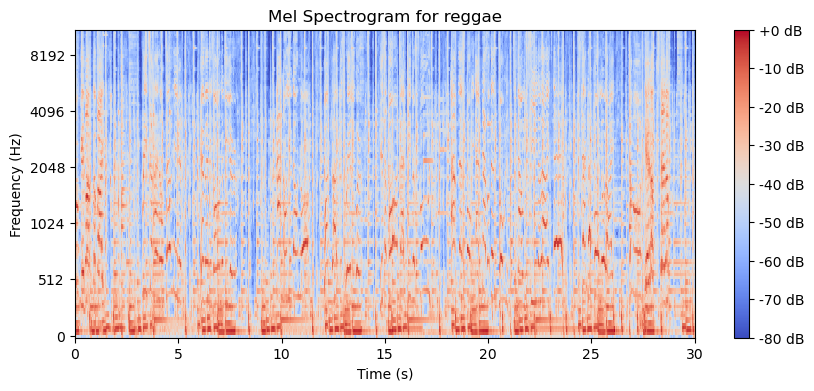

📢 Plotting spectrogram for: rock.00005.wav (rock)


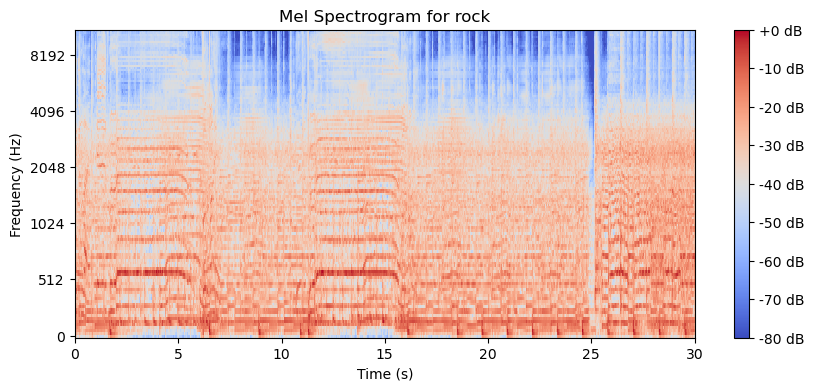

In [29]:
# Function to plot spectrogram
def plot_spectrogram(file_path, genre):
    y, sr = librosa.load(file_path, sr=None) 
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)  
    S_dB = librosa.power_to_db(S, ref=np.max)  

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", cmap="coolwarm")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram for {genre}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

# Loop through dataset to find "0005" files
for root, _, files in os.walk(data_path):
    genre = os.path.basename(root) 
    for file in files:
        if "00005" in file and file.lower().endswith((".mp3", ".wav", ".flac", ".aac", ".ogg")):
            file_path = os.path.join(root, file)
            print(f"📢 Plotting spectrogram for: {file} ({genre})")
            plot_spectrogram(file_path, genre)


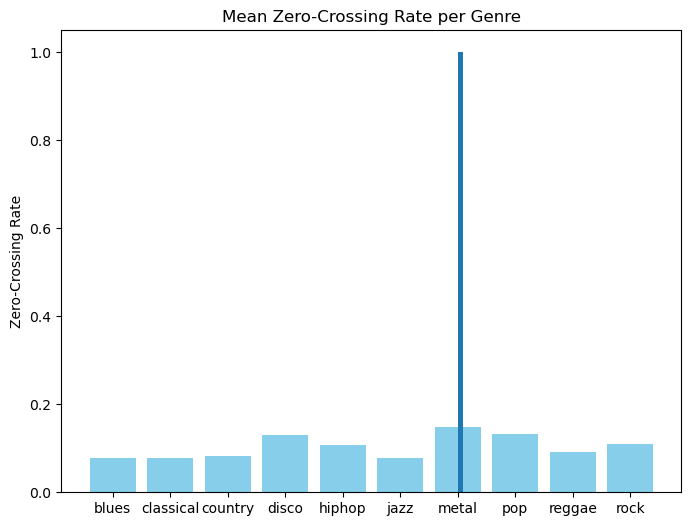

In [30]:
def plot_bar(df):
    genre_mean_zcr = df.groupby("Genre Name")["Zero-Crossing Rate"].mean().reset_index()

    plt.figure(figsize=(8, 6))
    plt.bar(genre_mean_zcr["Genre Name"], genre_mean_zcr["Zero-Crossing Rate"], color='skyblue')
    plt.hist(x = 6)
    plt.ylabel("Zero-Crossing Rate")
    plt.title("Mean Zero-Crossing Rate per Genre")
    plt.show()

plot_bar(df)

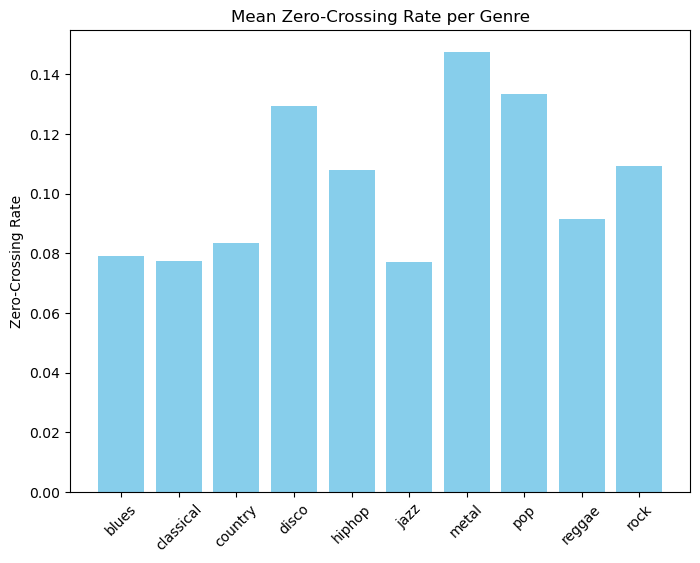

In [31]:
def plot_bar(df):
    genre_mean_zcr = df.groupby("Genre Name")["Zero-Crossing Rate"].mean().reset_index()

    plt.figure(figsize=(8, 6))
    plt.bar(genre_mean_zcr["Genre Name"], genre_mean_zcr["Zero-Crossing Rate"], color='skyblue')
    plt.xticks(rotation=45)
    plt.ylabel("Zero-Crossing Rate")
    plt.title("Mean Zero-Crossing Rate per Genre")
    plt.show()

plot_bar(df)

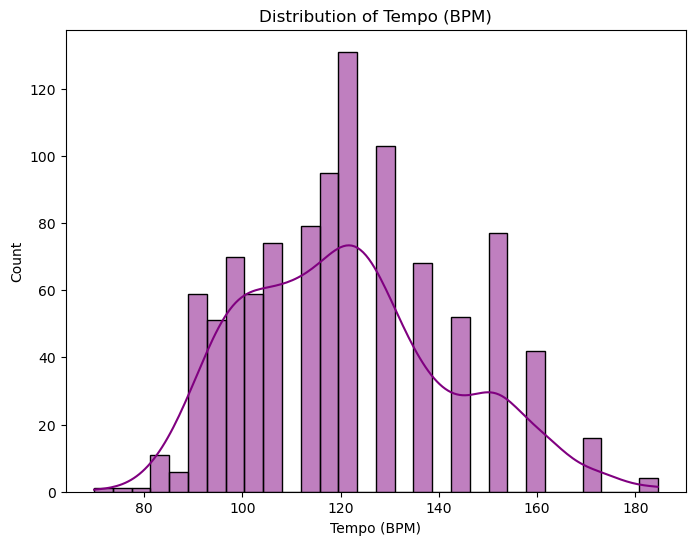

In [32]:
import seaborn as sns

def plot_histogram(df):
    plt.figure(figsize=(8, 6))
    sns.histplot(df["Tempo (BPM)"], bins=30, kde=True, color="purple")
    plt.title("Distribution of Tempo (BPM)")
    plt.show()

plot_histogram(df)

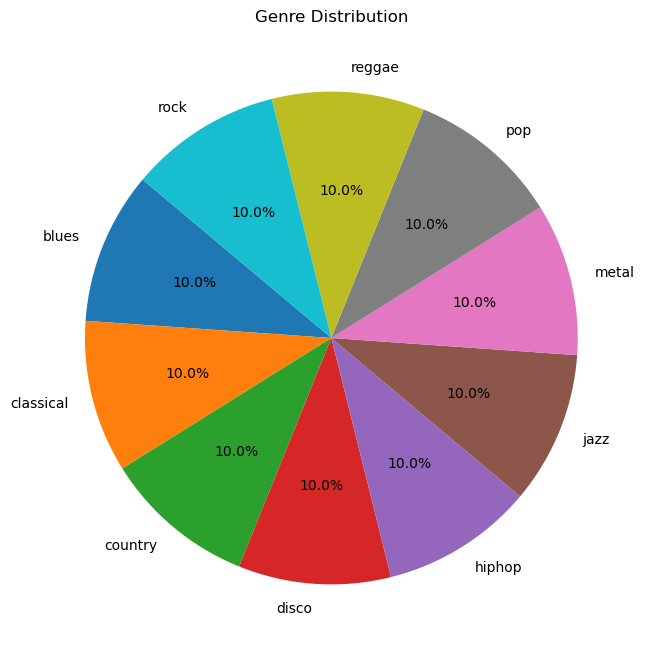

In [33]:
def plot_pie(df):
    genre_counts = df["Genre Name"].value_counts()

    plt.figure(figsize=(8, 8))
    plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title("Genre Distribution")
    plt.show()

plot_pie(df)

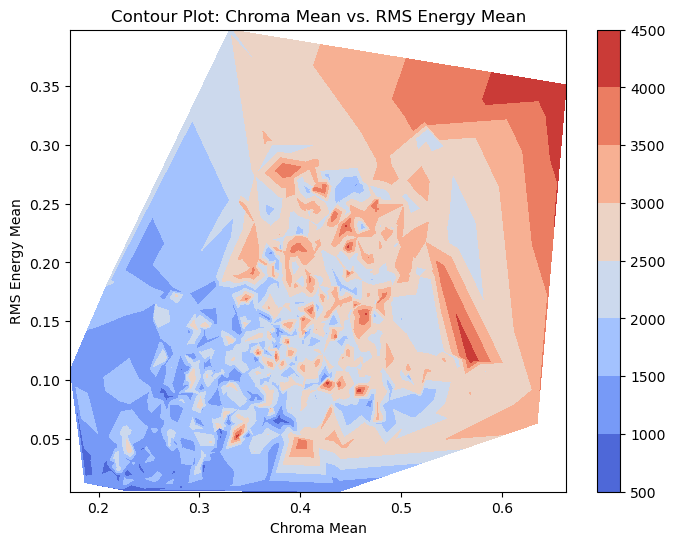

In [34]:
import numpy as np

def plot_contour(df):
    plt.figure(figsize=(8, 6))
    x = df["Chroma Mean"]
    y = df["RMS Energy Mean"]
    z = df["Spectral Centroid"]

    xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
    zi = plt.tricontourf(x, y, z, cmap="coolwarm")

    plt.colorbar(zi)
    plt.xlabel("Chroma Mean")
    plt.ylabel("RMS Energy Mean")
    plt.title("Contour Plot: Chroma Mean vs. RMS Energy Mean")
    plt.show()

plot_contour(df)

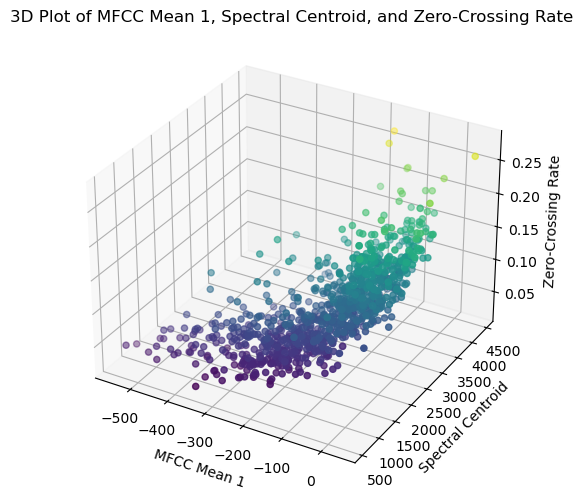

In [35]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(df):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    x = df["MFCC Mean 1"]
    y = df["Spectral Centroid"]
    z = df["Zero-Crossing Rate"]

    ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
    ax.set_xlabel("MFCC Mean 1")
    ax.set_ylabel("Spectral Centroid")
    ax.set_zlabel("Zero-Crossing Rate")
    ax.set_title("3D Plot of MFCC Mean 1, Spectral Centroid, and Zero-Crossing Rate")
    plt.show()

plot_3d(df)

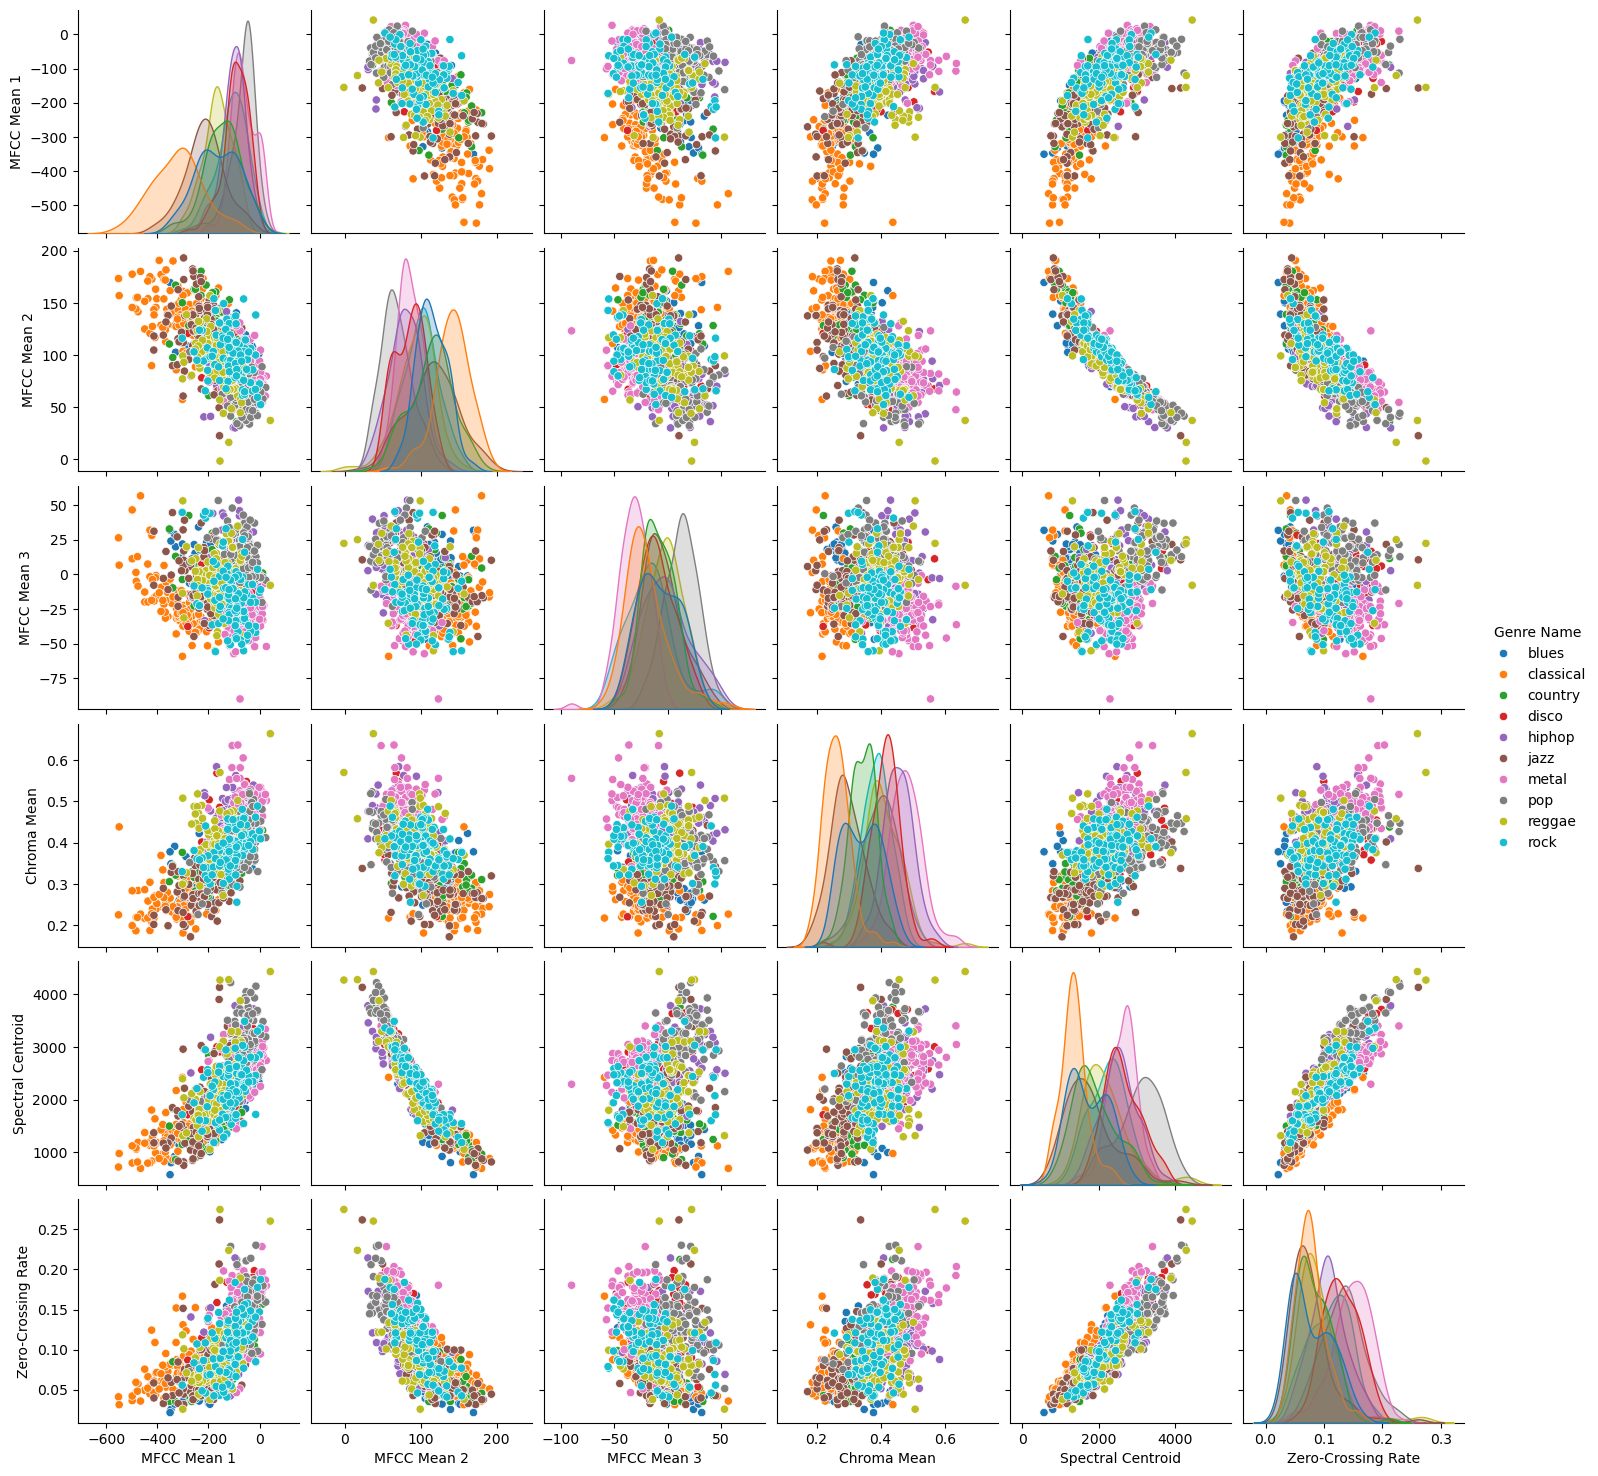

In [36]:
sns.pairplot(df, hue="Genre Name", vars=["MFCC Mean 1", "MFCC Mean 2", "MFCC Mean 3", 
                                         "Chroma Mean", "Spectral Centroid", "Zero-Crossing Rate"], palette="tab10")
plt.show()

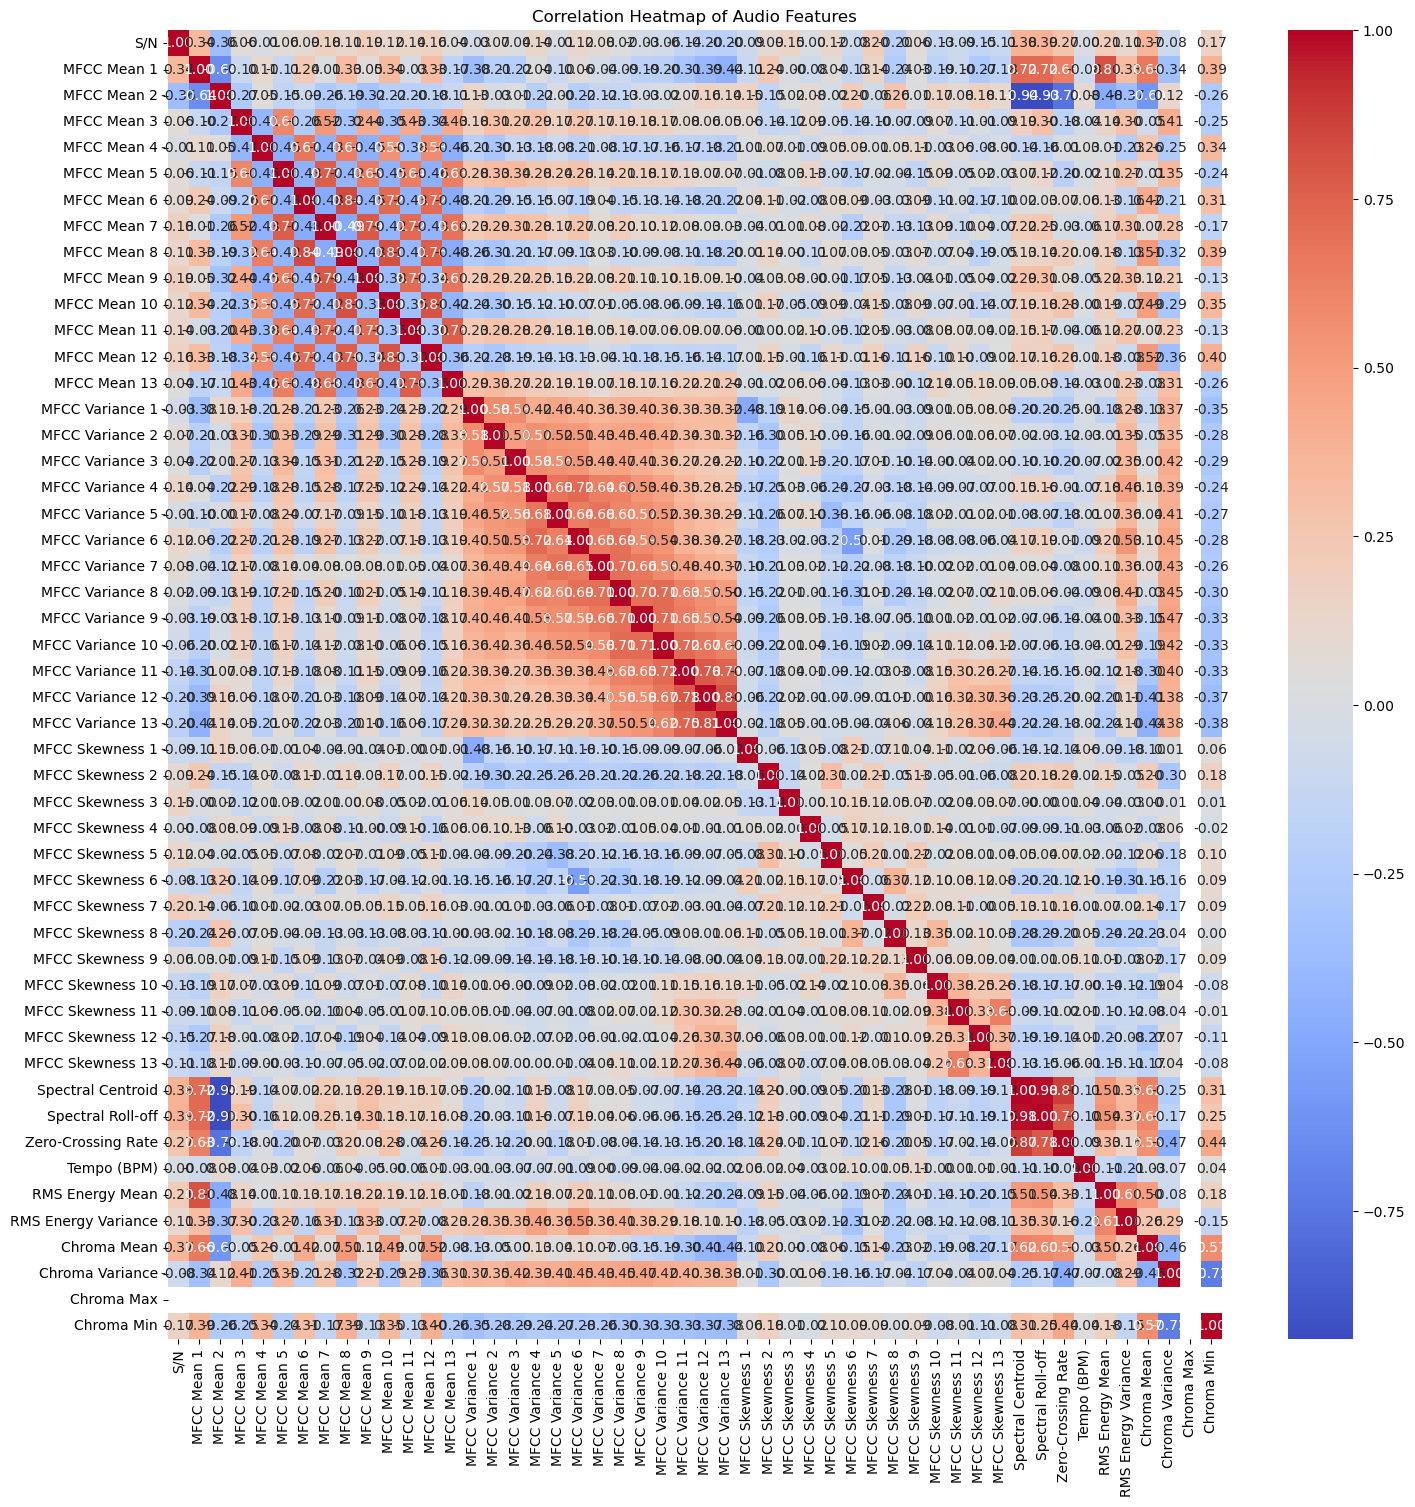

In [37]:
plt.figure(figsize=(17, 17))
corr_matrix = df.select_dtypes(include=[np.number]).corr()  
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Audio Features")
plt.show()

C:\Users\Ahjam\AppData\Local\Temp\ipykernel_9260\426036780.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Genre Name", y="Spectral Centroid", palette="Set2")


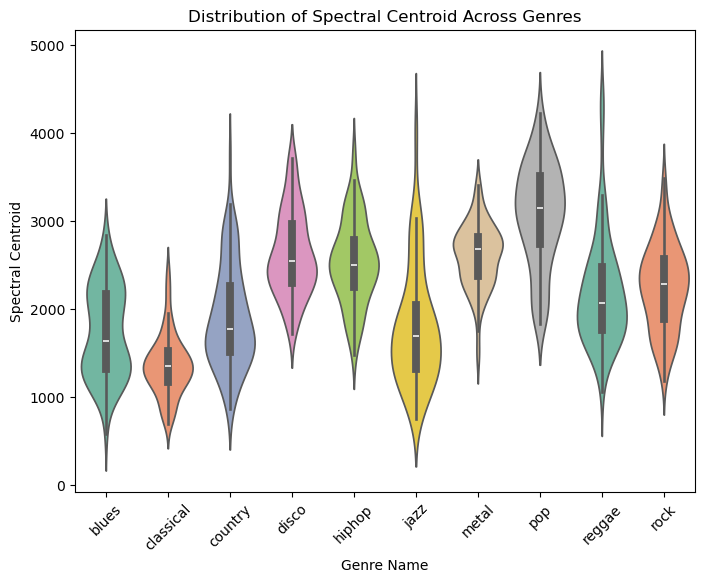

In [38]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x="Genre Name", y="Spectral Centroid", palette="Set2")
plt.xticks(rotation=45)
plt.title("Distribution of Spectral Centroid Across Genres")
plt.show()

C:\Users\Ahjam\AppData\Local\Temp\ipykernel_9260\3666299168.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Genre Name", y="Zero-Crossing Rate", palette="Set3")


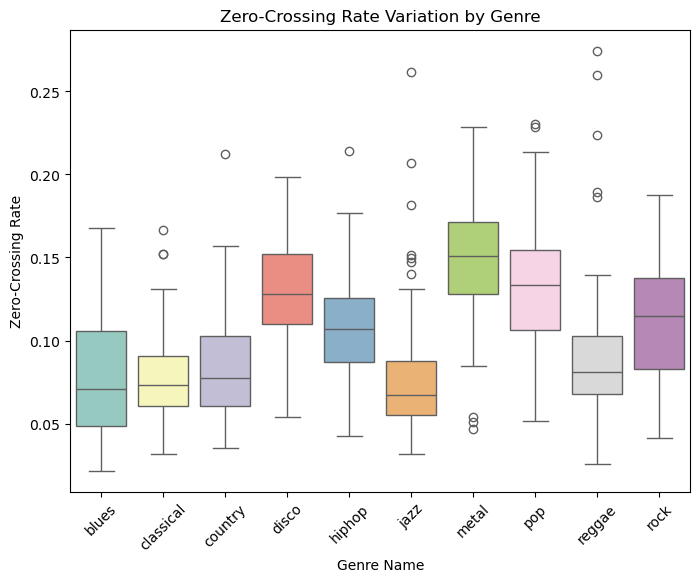

In [39]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="Genre Name", y="Zero-Crossing Rate", palette="Set3")
plt.xticks(rotation=45)
plt.title("Zero-Crossing Rate Variation by Genre")
plt.show()

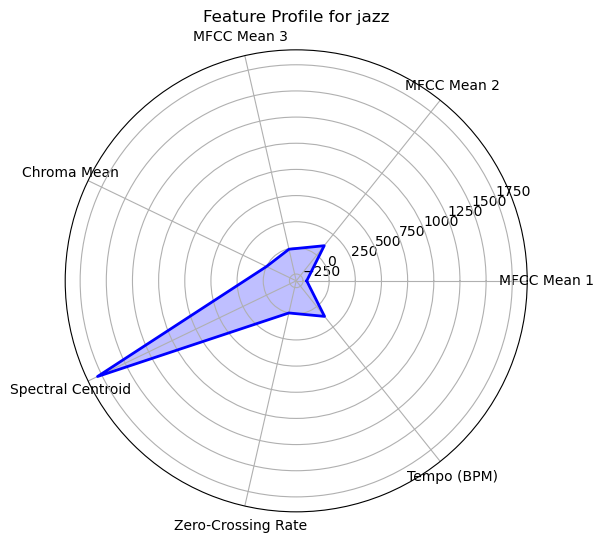

In [40]:
def plot_radar_chart(df, genre_name):
    features = ["MFCC Mean 1", "MFCC Mean 2", "MFCC Mean 3", 
                "Chroma Mean", "Spectral Centroid", "Zero-Crossing Rate", "Tempo (BPM)"]
    
    genre_df = df[df["Genre Name"] == genre_name][features].mean().values
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    values = np.append(genre_df, genre_df[0])  # Loop back to the first value
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    plt.title(f"Feature Profile for {genre_name}")
    plt.show()

# Example: Plot radar chart for Jazz
plot_radar_chart(df, "jazz")

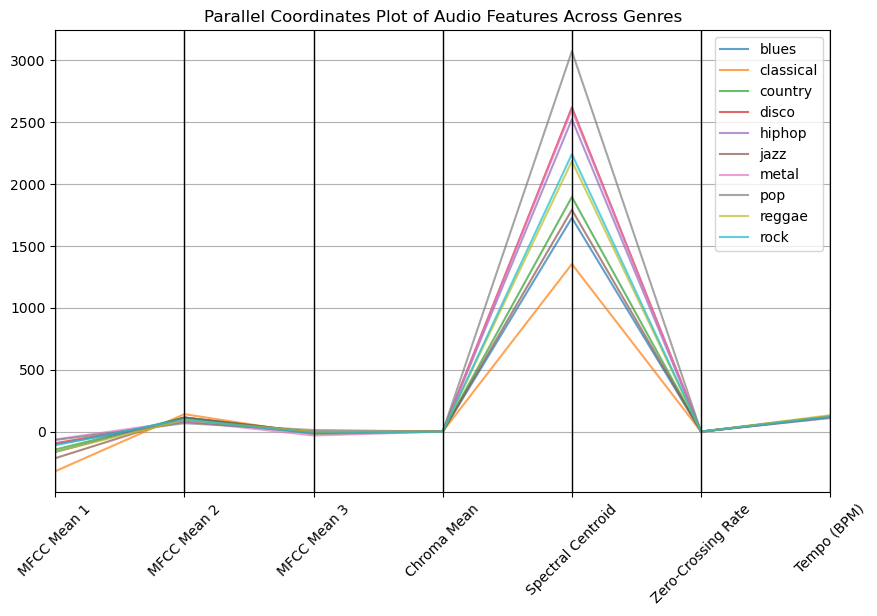

In [41]:
from pandas.plotting import parallel_coordinates

features = ["MFCC Mean 1", "MFCC Mean 2", "MFCC Mean 3", "Chroma Mean", 
            "Spectral Centroid", "Zero-Crossing Rate", "Tempo (BPM)"]
df_parallel = df.groupby("Genre Name")[features].mean().reset_index()

plt.figure(figsize=(10, 6))
parallel_coordinates(df_parallel, class_column="Genre Name", colormap="tab10", alpha=0.7)
plt.xticks(rotation=45)
plt.title("Parallel Coordinates Plot of Audio Features Across Genres")
plt.show()

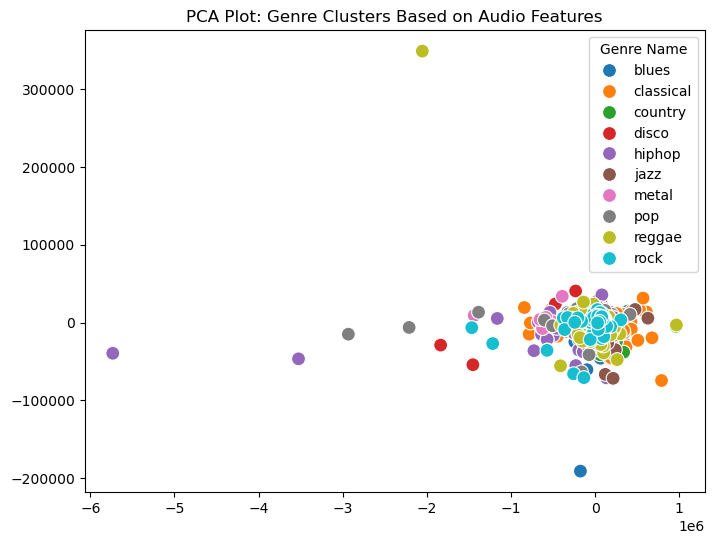

In [42]:
from sklearn.decomposition import PCA

# Select numerical features
numerical_df = df.select_dtypes(include=[np.number]).drop(columns=["S/N"])  
genre_labels = df["Genre Name"]

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numerical_df)

# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=genre_labels, palette="tab10", s=100)
plt.title("PCA Plot: Genre Clusters Based on Audio Features")
plt.show()

## Machine Learning Part

In [43]:
#Importing Libraries
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [44]:
# Machine Learning Pipeline
def train_classification_models(df):
    # Prepare features and labels
    X = df.iloc[:, 4:].values 
    y = LabelEncoder().fit_transform(df['Genre Name'])  

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'SVC': SVC(probability=True, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
        'K Neighbors': KNeighborsClassifier()
    }

    # Training and Evaluation
    for model_name, model in models.items():
        print(f"\n🔹 Training: {model_name}")
        accuracies = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)

        print(f"✅ Mean Accuracy: {np.mean(accuracies):.4f}")
        print(classification_report(y_test, y_pred))

# Call the function after dataset processing
if not df.empty:
    train_classification_models(df)

print("Model training completed!")



🔹 Training: Logistic Regression
✅ Mean Accuracy: 0.7060
              precision    recall  f1-score   support

           0       0.68      0.65      0.67        20
           1       0.94      0.80      0.86        20
           2       0.71      0.60      0.65        20
           3       0.73      0.80      0.76        20
           4       0.71      0.60      0.65        20
           5       0.76      0.95      0.84        20
           6       0.78      0.90      0.84        20
           7       0.69      0.55      0.61        20
           8       0.56      0.75      0.64        20
           9       0.65      0.55      0.59        20

    accuracy                           0.71       200
   macro avg       0.72      0.71      0.71       200
weighted avg       0.72      0.71      0.71       200


🔹 Training: Decision Tree
✅ Mean Accuracy: 0.4810
              precision    recall  f1-score   support

           0       0.42      0.50      0.45        20
           1       0.74 